# 使用SageMaker GPU多模型端点部署Stable Diffusion不同模型（Triton）

---

此notebook在us-west-2区域的CI测试结果如下。其他区域的CI测试结果可以在notebook末尾找到。

![This us-west-2 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://prod.us-west-2.tcx-beacon.docs.aws.dev/sagemaker-nb/us-west-2/inference|generativeai|llm-workshop|lab2-stable-diffusion|option3-triton-mme|sm-triton-python-stablediff.ipynb)

---

在这个notebook中，我们将在由NVIDIA Triton推理服务器支持的SageMaker多模型GPU端点（MME GPU）上部署Stable Diffusion的多个变体。
> ⚠ **警告**: 此notebook需要至少`ml.m5.large`实例来构建托管Stable Diffusion模型所需的conda环境。  

Skip to:
1. [安装和导入](#installs)
2. [下载预训练模型](#modelartifact)
3. [打包conda环境](#condaenv)
4. [部署到SageMaker实时端点](#deploy)
6. [查询模型](#query)
7. [清理资源](#cleanup)


### 第1部分 - 安装和导入 <a name="installs"></a>

In [ ]:
%pip install -U sagemaker pillow huggingface-hub conda-pack sagemaker-ssh-helper

In [17]:
import boto3
import sagemaker
from sagemaker import get_execution_role

import time
import json
from PIL import Image
import base64
from io import BytesIO
import numpy as np

from utils import download_model

from IPython.display import display

# 变量定义
s3_client = boto3.client("s3")
ts = time.strftime("%Y-%m-%d-%H-%M-%S", time.gmtime())

# sagemaker变量
role = get_execution_role()
sm_client = boto3.client(service_name="sagemaker")
runtime_sm_client = boto3.client("sagemaker-runtime")
sagemaker_session = sagemaker.Session(boto_session=boto3.Session())
bucket = sagemaker_session.default_bucket()
prefix = "stable-diffusion-mme"
default_bucket_prefix = sagemaker_session.default_bucket_prefix

# 如果指定了默认存储桶前缀，将其附加到s3路径
if default_bucket_prefix:
    prefix = f"{default_bucket_prefix}/{prefix}"

### 第2部分 - 保存预训练模型 <a name="modelartifact"></a>

`models`目录包含每个Stable Diffusion模型的推理代码和Triton配置文件。除此之外，我们还需要下载预训练的模型权重并将它们保存到`models`目录中相应的子目录中。一旦我们下载了这些，我们就可以将推理代码和模型权重打包成tarball并上传到S3。

In [ ]:
models_local_path = {
    "stabilityai/stable-diffusion-2-1-base": "models/sd_base/1/checkpoint",
    "stabilityai/stable-diffusion-2-depth": "models/sd_depth/1/checkpoint",
    "stabilityai/stable-diffusion-2-inpainting": "models/sd_inpaint/1/checkpoint",
    "stabilityai/stable-diffusion-x4-upscaler": "models/sd_upscale/1/checkpoint",
    # "Liberata/illustrious-xl-v1.0": "models/illustrious/1/checkpoint"
}

for model_name, model_local_path in models_local_path.items():
    download_model(model_name, model_local_path)

In [25]:
# Liberata/illustrious-xl-v1.0 不支持 snapshot_download
!hf download Liberata/illustrious-xl-v1.0 --local-dir models/illustrious/1/checkpoint --cache-dir ./tmp_cache

Fetching 3 files: 100%|█████████████████████████| 3/3 [00:00<00:00, 2711.83it/s]
/home/ec2-user/SageMaker/mme/option3-triton-mme/models/illustrious/1/checkpoint


### 第3部分 - 打包conda环境，扩展Sagemaker Triton容器 <a name="condaenv"></a>

当使用Triton Python后端（我们的Stable Diffusion模型将在其上运行）时，您可以包含自己的环境和依赖项。推荐的方法是使用[conda pack](https://conda.github.io/conda-pack/)生成`tar.gz`格式的conda环境存档，并在应该使用它的模型的`config.pbtxt`文件中指向它，添加以下代码片段：

```
parameters: {
  key: "EXECUTION_ENV_PATH",
  value: {string_value: "path_to_your_env.tar.gz"}
}

```
您可以为每个模型使用不同的环境，或者为所有模型使用相同的环境（在[这里](https://github.com/triton-inference-server/python_backend#creating-custom-execution-environments)阅读更多信息）。由于我们将要部署的所有模型都有相同的环境要求集，我们将创建一个单一的conda环境，并将使用Python后端将该环境复制到所有模型都可以访问的位置。

> ⚠ **警告**: 这里突出显示的创建共享conda环境的方法仅限于单实例部署。在自动扩展的情况下，无法保证新实例将配置conda环境。由于托管Stable Diffusion模型的conda环境相当大，生产部署的推荐方法是通过扩展Triton推理镜像来创建共享环境。  

让我们首先创建具有必要依赖项的conda环境；运行这些单元格将输出一个`sd_env.tar.gz`文件。

In [41]:
%%writefile environment.yml
name: mme_env
channels:
  - conda-forge
  - nvidia
  - pytorch
dependencies:
  - python=3.12.3
  - nvidia::cuda-toolkit=12.4
  - nvidia::cuda-runtime=12.4
  - gcc_linux-64=11
  - gxx_linux-64=11
  - ninja
  - pytorch::pytorch-cuda=12.4
  - pip
  - pip:
      - torch==2.6.0
      - torchvision
      - torchaudio
      - sagemaker-ssh-helper
      - numpy
      - accelerate
      - transformers
      - diffusers
      - conda-pack
      - safetensors
      - xformers==0.0.29


Overwriting environment.yml


现在我们可以使用上面的环境yaml规范创建环境

🛈 创建conda环境可能需要5分钟。确保您在`ml.m5.large`或更高版本的实例中运行此notebook

In [4]:
!export PYTHONNOUSERSITE=True
!conda env create -f environment.yml

In [43]:
!conda pack -n mme_env -o models/setup_conda/sd_env.tar.gz # --force

/home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/conda_pack/core.py:16: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
Packing environment at '/home/ec2-user/anaconda3/envs/mme_env' to 'models/setup_conda/sd_env.tar.gz'
[########################################] | 100% Completed |  7min  6.2s


### 第4部分 - 部署端点 <a name="deploy"></a>

现在，我们获取SageMaker Triton容器镜像的正确URI。查看AWS维护的所有可用深度学习容器镜像[这里](https://github.com/aws/deep-learning-containers/blob/master/available_images.md)。 

In [6]:
region = boto3.Session().region_name


from sagemaker import image_uris

triton_framework = "sagemaker-tritonserver"
region="us-east-1"
instance_type="ml.g5.xlarge"

available_versions = list(image_uris.config_for_framework(triton_framework)['versions'].keys())
mme_triton_image_uri = image_uris.retrieve(framework=triton_framework, region=region, instance_type=instance_type, version=available_versions[0])

下一步是将模型子目录和权重打包成单独的tarball并上传到S3。这个过程大约需要10到15分钟。

In [9]:
from pathlib import Path

model_root_path = Path("./models")
model_dirs = list(model_root_path.glob("*"))

In [ ]:
model_upload_paths = {}
for model_path in model_dirs:
    model_name = model_path.name
    if model_name != "illustrious":
        continue
    tar_name = model_path.name + ".tar.gz"
    !tar -C $model_root_path -czvf $tar_name $model_name
    model_upload_paths[model_name] = sagemaker_session.upload_data(
        path=tar_name, bucket=bucket, key_prefix=prefix
    )
    !rm $tar_name

我们现在准备配置和部署多模型端点

In [19]:
model_data_url = f"s3://{bucket}/{prefix}/"  # 存储模型的s3位置
ts = time.strftime("%Y-%m-%d-%H-%M-%S", time.gmtime())

container = {
    "Image": mme_triton_image_uri,
    "ModelDataUrl": model_data_url,
    "Mode": "MultiModel",
}

In [21]:
from sagemaker.multidatamodel import MultiDataModel
from sagemaker_ssh_helper.wrapper import SSHModelWrapper, SSHMultiModelWrapper

sm_model_name = f"{prefix}-mdl-{ts}"

create_model_response = sm_client.create_model(
    ModelName=sm_model_name, ExecutionRoleArn=role, PrimaryContainer=container,
    # dependencies=[SSHModelWrapper.dependency_dir()]
)

print("模型ARN: " + create_model_response["ModelArn"])

Model Arn: arn:aws:sagemaker:us-east-1:596899493901:model/stable-diffusion-mme-mdl-2025-10-31-07-26-26


创建SageMaker端点配置。

In [22]:
endpoint_config_name = f"{prefix}-epc-{ts}"
instance_type = "ml.g5.xlarge"

create_endpoint_config_response = sm_client.create_endpoint_config(
    EndpointConfigName=endpoint_config_name,
    ProductionVariants=[
        {
            "InstanceType": instance_type,
            "InitialVariantWeight": 1,
            "InitialInstanceCount": 1,
            "ModelName": sm_model_name,
            "VariantName": "AllTraffic",
            "InferenceAmiVersion": "al2-ami-sagemaker-inference-gpu-3-1"
        }
    ],
)

print("端点配置ARN: " + create_endpoint_config_response["EndpointConfigArn"])

Endpoint Config Arn: arn:aws:sagemaker:us-east-1:596899493901:endpoint-config/stable-diffusion-mme-epc-2025-10-31-07-26-26


创建端点，并等待其转换为`InService`状态。

In [23]:
endpoint_name = f"{prefix}-ep-{ts}"

create_endpoint_response = sm_client.create_endpoint(
    EndpointName=endpoint_name, EndpointConfigName=endpoint_config_name
)

print("端点ARN: " + create_endpoint_response["EndpointArn"])

Endpoint Arn: arn:aws:sagemaker:us-east-1:596899493901:endpoint/stable-diffusion-mme-ep-2025-10-31-07-26-26


In [24]:
resp = sm_client.describe_endpoint(EndpointName=endpoint_name)
status = resp["EndpointStatus"]
print("状态: " + status)

while status == "Creating":
    time.sleep(30)
    resp = sm_client.describe_endpoint(EndpointName=endpoint_name)
    status = resp["EndpointStatus"]
    print("状态: " + status)

print("ARN: " + resp["EndpointArn"])
print("状态: " + status)

Status: Creating
Status: Creating
Status: Creating
Status: Creating
Status: Creating
Status: Creating
Status: Creating
Status: Creating
Status: Creating
Status: Creating
Status: InService
Arn: arn:aws:sagemaker:us-east-1:596899493901:endpoint/stable-diffusion-mme-ep-2025-10-31-07-26-26
Status: InService


### 查询模型 <a name="query"></a>
端点现在已部署，我们可以查询各个模型

在调用任何Stable Diffusion模型之前，我们首先调用`setup_conda`，它将conda环境复制到可以与所有其他模型共享的目录中。有关实现的更多详细信息，请参阅`models/setup_conda/1`目录中的[model.py](./models/setup_conda/1/model.py)文件。

In [26]:
# 调用setup_conda模型来创建共享的conda环境

payload = {
    "inputs": [
        {
            "name": "TEXT",
            "shape": [1],
            "datatype": "BYTES",
            "data": ["hello"],  # dummy data not used by the model
        }
    ]
}

response = runtime_sm_client.invoke_endpoint(
    EndpointName=endpoint_name,
    ContentType="application/octet-stream",
    Body=json.dumps(payload),
    TargetModel="setup_conda.tar.gz",
)

In [27]:
result = json.loads(response['Body'].read().decode())
result

{'model_name': 'setup_conda.tar.gz',
 'model_version': '1',
 'outputs': [{'name': 'conda_env_path',
   'datatype': 'BYTES',
   'shape': [],
   'data': ['/tmp/conda/sd_env.tar.gz']}]}

In [28]:
# 编码和解码图像的辅助函数
def encode_image(image):
    buffer = BytesIO()
    image.save(buffer, format="JPEG")
    img_str = base64.b64encode(buffer.getvalue())

    return img_str


def decode_image(img):
    buff = BytesIO(base64.b64decode(img.encode("utf8")))
    image = Image.open(buff)
    return image



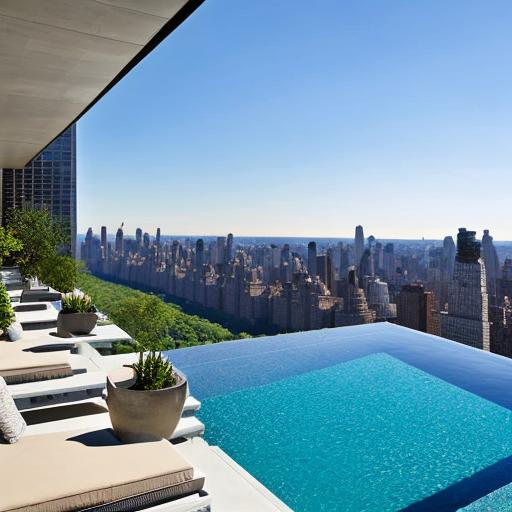

In [29]:
inputs = dict(
    prompt="Infinity pool on top of a high rise overlooking Central Park",
    negative_prompt="blur, signature, low detail, low quality",
    gen_args=json.dumps(dict(num_inference_steps=50, guidance_scale=8)),
)

payload = {
    "inputs": [
        {"name": name, "shape": [1, 1], "datatype": "BYTES", "data": [data]}
        for name, data in inputs.items()
    ]
}

response = runtime_sm_client.invoke_endpoint(
    EndpointName=endpoint_name,
    ContentType="application/octet-stream",
    Body=json.dumps(payload),
    TargetModel="sd_base.tar.gz",
)
output = json.loads(response["Body"].read().decode("utf8"))["outputs"]
original_image = decode_image(output[0]["data"][0])
original_image

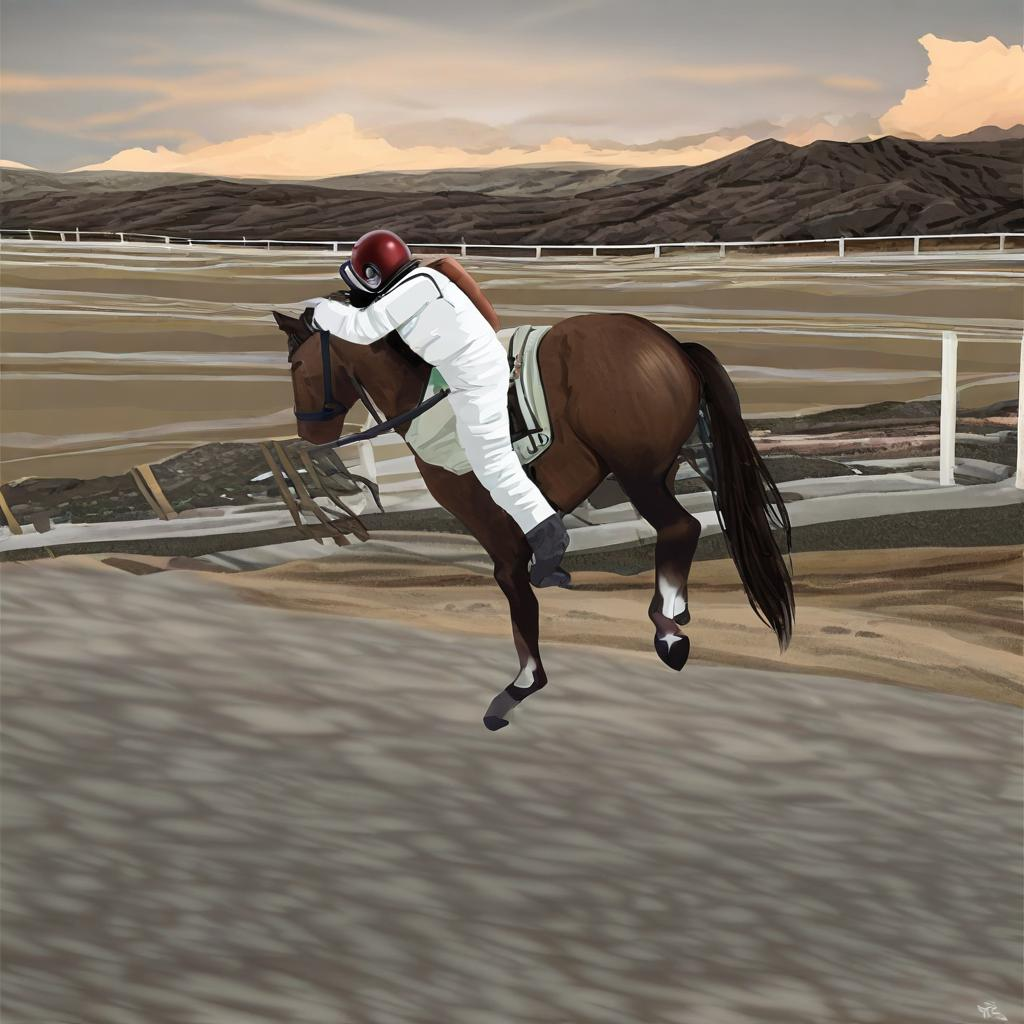

In [ ]:
inputs = dict(
    prompt="Infinity pool on top of a high rise overlooking Central Park",
)

payload = {
    "inputs": [
        {"name": name, "shape": [1, 1], "datatype": "BYTES", "data": [data]}
        for name, data in inputs.items()
    ]
}

response = runtime_sm_client.invoke_endpoint(
    EndpointName=endpoint_name,
    ContentType="application/octet-stream",
    Body=json.dumps(payload),
    TargetModel="illustrious.tar.gz",
)
output = json.loads(response["Body"].read().decode("utf8"))["outputs"]
original_image = decode_image(output[0]["data"][0])
original_image

使用同一个模型将原始图像的风格改变为油画，或者将场景从纽约中央公园改变为黄石国家公园，同时保持原始图像的方向。

Original image


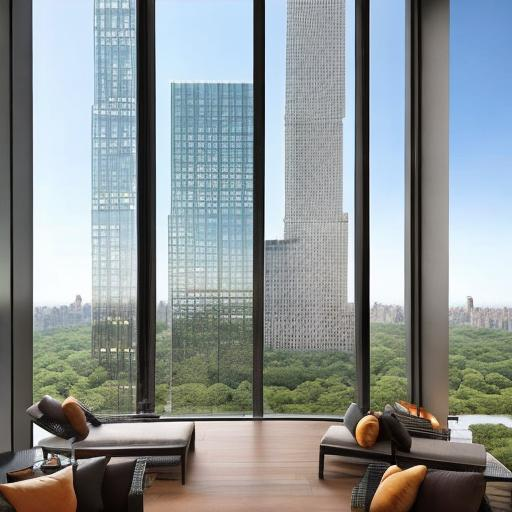

Oil painting


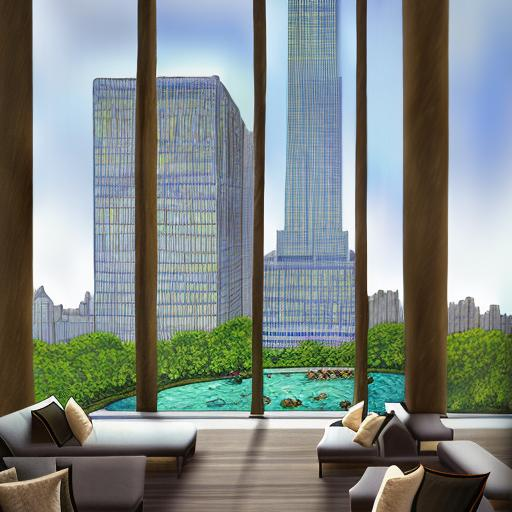

Yellowstone


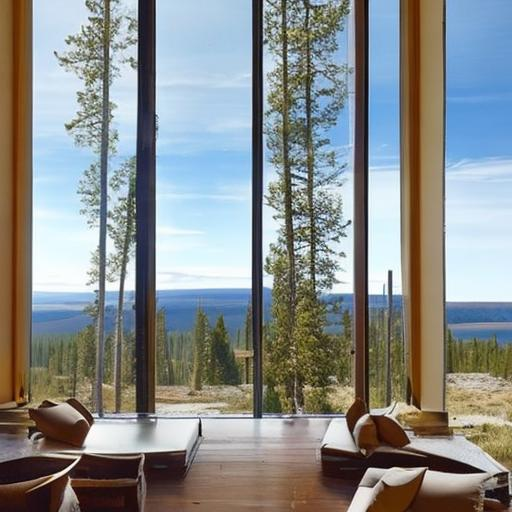

In [64]:
input_image = encode_image(original_image).decode("utf8")

inputs = dict(
    prompt="highly detailed oil painting of an inifinity pool overlooking central park",
    image=input_image,
    gen_args=json.dumps(dict(num_inference_steps=50, strength=0.8)),
)


payload = {
    "inputs": [
        {"name": name, "shape": [1, 1], "datatype": "BYTES", "data": [data]}
        for name, data in inputs.items()
    ]
}

response = runtime_sm_client.invoke_endpoint(
    EndpointName=endpoint_name,
    ContentType="application/octet-stream",
    Body=json.dumps(payload),
    TargetModel="sd_depth.tar.gz",
)
output = json.loads(response["Body"].read().decode("utf8"))["outputs"]
oil_painting = decode_image(output[0]["data"][0])


inputs = dict(
    prompt="Infinity pool perched on a cliff overlooking Yellowstone National Park ",
    image=input_image,
    gen_args=json.dumps(dict(num_inference_steps=50, strength=0.8)),
)


payload = {
    "inputs": [
        {"name": name, "shape": [1, 1], "datatype": "BYTES", "data": [data]}
        for name, data in inputs.items()
    ]
}

response = runtime_sm_client.invoke_endpoint(
    EndpointName=endpoint_name,
    ContentType="application/octet-stream",
    Body=json.dumps(payload),
    TargetModel="sd_depth.tar.gz",
)
output = json.loads(response["Body"].read().decode("utf8"))["outputs"]
rocky_mountains = decode_image(output[0]["data"][0])


print("Original image")
display(original_image)

print("Oil painting")
display(oil_painting)

print("Yellowstone")
display(rocky_mountains)

source image


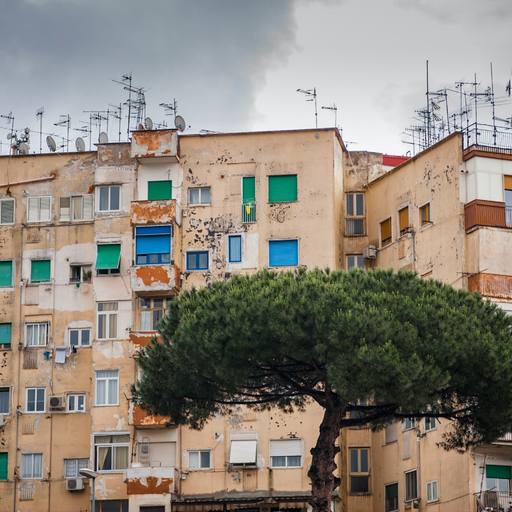

filled image


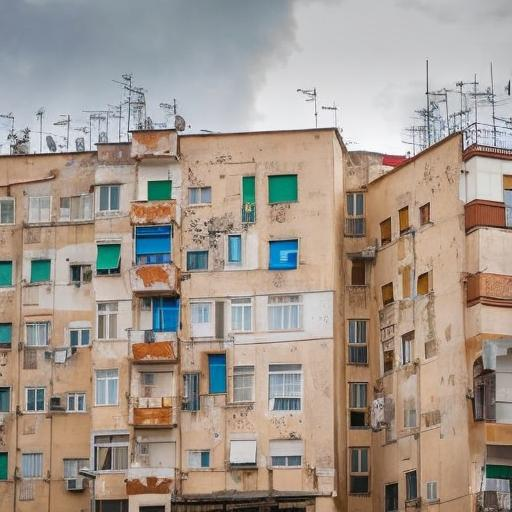

In [65]:
source_image = Image.open("sample_images/bertrand-gabioud.png")

image = encode_image(source_image).decode("utf8")
mask_image = encode_image(Image.open("sample_images/bertrand-gabioud-mask.png")).decode("utf8")
inputs = dict(
    prompt="building, facade, paint, windows",
    image=image,
    mask_image=mask_image,
    negative_prompt="tree, obstruction, sky, clouds",
    gen_args=json.dumps(dict(num_inference_steps=50, guidance_scale=10)),
)


payload = {
    "inputs": [
        {"name": name, "shape": [1, 1], "datatype": "BYTES", "data": [data]}
        for name, data in inputs.items()
    ]
}

response = runtime_sm_client.invoke_endpoint(
    EndpointName=endpoint_name,
    ContentType="application/octet-stream",
    Body=json.dumps(payload),
    TargetModel="sd_inpaint.tar.gz",
)
output = json.loads(response["Body"].read().decode("utf8"))["outputs"]
print("source image")
display(source_image)

print("filled image")
display(decode_image(output[0]["data"][0]))

在最后一个示例中，我们将把原始输出图像从512x512缩小到128x128。然后我们将使用放大模型将图像重新放大回原来的512分辨率。

Low res image


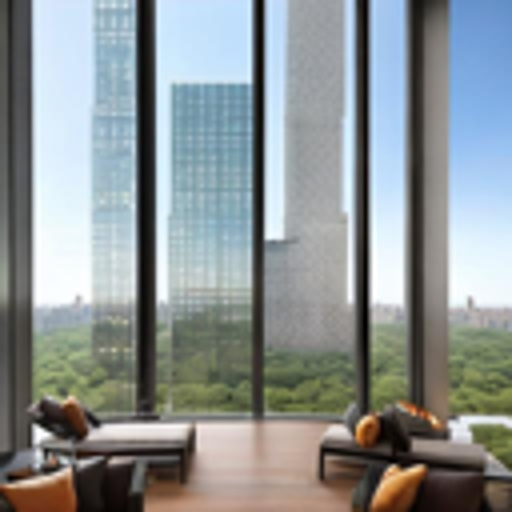

Upscaled image


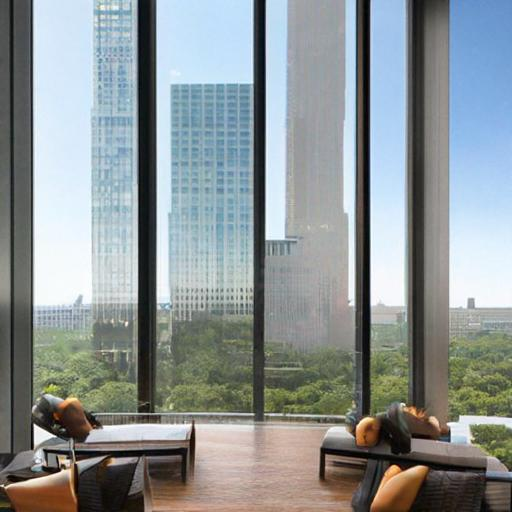

In [66]:
low_res_image = original_image.resize((128, 128))
inputs = dict(
    prompt="Infinity pool on top of a high rise overlooking Central Park",
    image=encode_image(low_res_image).decode("utf8"),
)

payload = {
    "inputs": [
        {"name": name, "shape": [1, 1], "datatype": "BYTES", "data": [data]}
        for name, data in inputs.items()
    ]
}

response = runtime_sm_client.invoke_endpoint(
    EndpointName=endpoint_name,
    ContentType="application/octet-stream",
    Body=json.dumps(payload),
    TargetModel="sd_upscale.tar.gz",
)
output = json.loads(response["Body"].read().decode("utf8"))["outputs"]
upscaled_image = decode_image(output[0]["data"][0])

print("Low res image")
display(low_res_image.resize((512, 512)))

print("Upscaled image")
display(upscaled_image)

## 清理资源 <a name="query"></a>

In [18]:
sm_client.delete_endpoint(EndpointName=endpoint_name)
sm_client.delete_endpoint_config(EndpointConfigName=endpoint_config_name)
sm_client.delete_model(ModelName=sm_model_name)

{'ResponseMetadata': {'RequestId': '141600e2-0f1a-4bb0-952c-63b16dd77f4b',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': '141600e2-0f1a-4bb0-952c-63b16dd77f4b',
   'strict-transport-security': 'max-age=47304000; includeSubDomains',
   'x-frame-options': 'DENY',
   'content-security-policy': "frame-ancestors 'none'",
   'cache-control': 'no-cache, no-store, must-revalidate',
   'x-content-type-options': 'nosniff',
   'content-type': 'application/x-amz-json-1.1',
   'date': 'Fri, 31 Oct 2025 07:23:36 GMT',
   'content-length': '0'},
  'RetryAttempts': 0}}

In [ ]:
# delete models in respective paths
for model_name, model_local_path in models_local_path.items():
    !rm -rf $model_local_path

## Notebook CI Test Results

This notebook was tested in multiple regions. The test results are as follows, except for us-west-2 which is shown at the top of the notebook.


![This us-east-1 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://prod.us-west-2.tcx-beacon.docs.aws.dev/sagemaker-nb/us-east-1/inference|generativeai|llm-workshop|lab2-stable-diffusion|option3-triton-mme|sm-triton-python-stablediff.ipynb)

![This us-east-2 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://prod.us-west-2.tcx-beacon.docs.aws.dev/sagemaker-nb/us-east-2/inference|generativeai|llm-workshop|lab2-stable-diffusion|option3-triton-mme|sm-triton-python-stablediff.ipynb)

![This us-west-1 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://prod.us-west-2.tcx-beacon.docs.aws.dev/sagemaker-nb/us-west-1/inference|generativeai|llm-workshop|lab2-stable-diffusion|option3-triton-mme|sm-triton-python-stablediff.ipynb)

![This ca-central-1 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://prod.us-west-2.tcx-beacon.docs.aws.dev/sagemaker-nb/ca-central-1/inference|generativeai|llm-workshop|lab2-stable-diffusion|option3-triton-mme|sm-triton-python-stablediff.ipynb)

![This sa-east-1 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://prod.us-west-2.tcx-beacon.docs.aws.dev/sagemaker-nb/sa-east-1/inference|generativeai|llm-workshop|lab2-stable-diffusion|option3-triton-mme|sm-triton-python-stablediff.ipynb)

![This eu-west-1 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://prod.us-west-2.tcx-beacon.docs.aws.dev/sagemaker-nb/eu-west-1/inference|generativeai|llm-workshop|lab2-stable-diffusion|option3-triton-mme|sm-triton-python-stablediff.ipynb)

![This eu-west-2 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://prod.us-west-2.tcx-beacon.docs.aws.dev/sagemaker-nb/eu-west-2/inference|generativeai|llm-workshop|lab2-stable-diffusion|option3-triton-mme|sm-triton-python-stablediff.ipynb)

![This eu-west-3 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://prod.us-west-2.tcx-beacon.docs.aws.dev/sagemaker-nb/eu-west-3/inference|generativeai|llm-workshop|lab2-stable-diffusion|option3-triton-mme|sm-triton-python-stablediff.ipynb)

![This eu-central-1 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://prod.us-west-2.tcx-beacon.docs.aws.dev/sagemaker-nb/eu-central-1/inference|generativeai|llm-workshop|lab2-stable-diffusion|option3-triton-mme|sm-triton-python-stablediff.ipynb)

![This eu-north-1 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://prod.us-west-2.tcx-beacon.docs.aws.dev/sagemaker-nb/eu-north-1/inference|generativeai|llm-workshop|lab2-stable-diffusion|option3-triton-mme|sm-triton-python-stablediff.ipynb)

![This ap-southeast-1 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://prod.us-west-2.tcx-beacon.docs.aws.dev/sagemaker-nb/ap-southeast-1/inference|generativeai|llm-workshop|lab2-stable-diffusion|option3-triton-mme|sm-triton-python-stablediff.ipynb)

![This ap-southeast-2 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://prod.us-west-2.tcx-beacon.docs.aws.dev/sagemaker-nb/ap-southeast-2/inference|generativeai|llm-workshop|lab2-stable-diffusion|option3-triton-mme|sm-triton-python-stablediff.ipynb)

![This ap-northeast-1 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://prod.us-west-2.tcx-beacon.docs.aws.dev/sagemaker-nb/ap-northeast-1/inference|generativeai|llm-workshop|lab2-stable-diffusion|option3-triton-mme|sm-triton-python-stablediff.ipynb)

![This ap-northeast-2 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://prod.us-west-2.tcx-beacon.docs.aws.dev/sagemaker-nb/ap-northeast-2/inference|generativeai|llm-workshop|lab2-stable-diffusion|option3-triton-mme|sm-triton-python-stablediff.ipynb)

![This ap-south-1 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://prod.us-west-2.tcx-beacon.docs.aws.dev/sagemaker-nb/ap-south-1/inference|generativeai|llm-workshop|lab2-stable-diffusion|option3-triton-mme|sm-triton-python-stablediff.ipynb)
